# PyParticleBunch Ideas
### A place to test features

---
## Current Ideas:
- [x] Define what a particle is (minimum and additional co-ordinates)
- [x] Define what a bunch of particles is
- [x] Define fast methods of accessing particle co-ordinates at the bunch level
- [x] Function to print particle co-ordinates to file (particle level and bunch level)
- [x] Function to read particle co-ordinates from file (particle level and bunch level)
- [ ] Plotting suite - make nice plots of the distribution in real space and phase space
- [ ] Generate a uniform distribution
- [ ] Generate a Gaussian distribution
- [ ] Match a distribution to the accelerator lattice (Advanced)

---
# Definition of a particle

Let's start with the definition of a particle given in the MAD-X manual:

> ## 1.7.1 Canonical Variables Describing Orbits
> 
> MAD-X uses the following canonical variables to describe the motion of particles:
> - **X** Horizontal position x of the (closed) orbit, referred to the ideal orbit [m].
> - **PX** Horizontal canonical momentum px of the (closed) orbit referred to the ideal orbit, divided by the reference momentum: PX = px/p0
> - **Y** Vertical position y of the (closed) orbit, referred to the ideal orbit [m].
> - **PY** Vertical canonical momentum py of the (closed) orbit referred to the ideal orbit, divided by the reference momentum: PY = py/p0
> - **T** Velocity of light times the negative time difference with respect to the reference particle: T = −ct, [m]. A positive T means that the particle arrives ahead of the reference particle.
> - **PT** Energy error, divided by the reference momentum times the velocity of light: PT = ∆E/psc. This value is only non-zero when synchrotron motion is present. It describes the deviation of the particle from the orbit of a particle with the momentum error DELTAP.
> - **DELTAP** Difference between the reference momentum and the design momentum, divided by the design momentum: DELTAP = ∆p/p0,.  This quantity is used to normalize all element strengths.
> -The independent variable is: **S** Arc length s along the reference orbit, [m].
> - In the limit of fully relativistic particles (γ >> 1, v = c, pc = E), the variables T, PT used here agree with the longitudinal variables used in TRANSPORT. This means that T becomes the negative path length difference, while PT becomes the fractional momentum error. The reference momentum ps must be constant in order to keep the system canonical.


#### Conversion from Px to x'
$$ P_x = \left( 1 + \frac{\Delta P}{p_0} \right) x^{\prime} $$

Thus for small $\frac{\Delta P}{p_0}$ we may assume $P_x \approx x^{\prime}$


In [1]:
import numpy as np
import os
import pickle
import pandas as pnd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

### Definition of a MADX/PTC particle object

In [2]:
class Particle:
    def __init__(self, x, xp, y, yp, t, pt):
        self.__x = float(x)
        self.__xp = float(xp)
        self.__y = float(y)
        self.__yp = float(yp)
        self.__t = float(t)
        self.__pt = float(pt)
        
    @classmethod
    def fromfileline(cls, filename, n):        
        data = open(filename).readlines()
        data_line = data[n]
        input_coords = [x for x in data_line.split()]
        return cls(input_coords[0], input_coords[1], input_coords[2], input_coords[3], input_coords[4], input_coords[5])
    
    @classmethod
    def empty(cls):        
        return cls(0., 0., 0., 0., 0., 0.)
    
    def set_verbose(self): self.__verbose=True
        
    def get_coordinates(self):
        return np.array([self.__x, self.__xp, self.__y, self.__yp, self.__t, self.__pt])
    
    def get_x(self): return self.__x
    def get_xp(self): return self.__xp
    def get_y(self): return self.__y
    def get_yp(self): return self.__yp
    def get_t(self): return self.__t
    def get_pt(self): return self.__pt
    
    def set_x(self, x): self.__x = float(x)
    def set_xp(self, xp): self.__xp = float(xp)
    def set_y(self, y): self.__y = float(y)
    def set_yp(self, yp): self.__yp = float(yp)
    def set_t(self, t): self.__t = float(t)
    def set_pt(self, pt): self.__pt = float(pt)
        
    def MatrixMultiply(self, M):
        # Check Matrix is 6x6
        if M.shape == (6,6):
            p_i = np.array([self.__x,self.__xp,self.__y,self.__yp,self.__t,self.__pt])
            p_f = np.matmul(M, p_i)
            
            self.set_x(p_f[0])
            self.set_xp(p_f[1])
            self.set_y(p_f[2])
            self.set_yp(p_f[3])
            self.set_t(p_f[4])
            self.set_pt(p_f[5])
        else:
            print('Particle::MatrixMultiply: Matrix shape unexpected: ', M.shape)        
        
    def file_string(self):
        filestring = str(self.get_x())+ \
        '\t'+str(self.get_xp())+ \
        '\t'+str(self.get_y())+ \
        '\t'+str(self.get_yp())+ \
        '\t'+str(self.get_t())+ \
        '\t'+str(self.get_pt())+'\n'
        return filestring
    
    def MADX_string(self):
        MADX_filestring = 'start, x='+str(self.get_x())+ \
        ', px='+str(self.get_xp())+ \
        ', y='+str(self.get_y())+ \
        ', py='+str(self.get_yp())+ \
        ', t='+str(self.get_t())+ \
        ', pt='+str(self.get_pt())+';\n'
        return MADX_filestring
    
    def PTC_string(self):
        PTC_filestring = 'ptc_start, x='+str(self.get_x())+ \
        ', px='+str(self.get_xp())+ \
        ', y='+str(self.get_y())+ \
        ', py='+str(self.get_yp())+ \
        ', t='+str(self.get_t())+ \
        ', pt='+str(self.get_pt())+';\n'
        return PTC_filestring
        
    def add_to_file(self, filename):
        if os.path.isfile(filename):
            f = open(filename, 'a')
        else:
            f = open(filename, 'w')      
        f.write(self.file_string())
        f.close()
        
    def add_to_MADX_file(self, filename):
        if os.path.isfile(filename):
            f = open(filename, 'a')
        else:
            f = open(filename, 'w')        
        f.write(self.MADX_string())
        f.close()
        
    def add_to_PTC_file(self, filename):
        if os.path.isfile(filename):
            f = open(filename, 'a')
        else:
            f = open(filename, 'w')        
        f.write(self.PTC_string())
        f.close()
    

#### Tests of Particle constructors
- Create instance of MADX_Particle with the default constructor
- Create instance of MADX_Particle with the empty constructor
- Create instance of MADX_Particle with fromfileline constructor
- Create instances of PTC_Particle with all constructors

In [3]:
test_particle = Particle(0.001, 0., 0., 0., 0., 0.)

In [4]:
test_particle2 = Particle.empty()

In [5]:
f = open('MADX_input_particle.txt', 'w')
f.write('0.01\t0.3\t0.5\t0.0\t0.0\t0.0\n')
f.close()
test_particle3 = Particle.fromfileline('MADX_input_particle.txt',0)

In [6]:
test_particle4 = Particle(0.001, 0., 0., 0., 0., 0.)

In [7]:
test_particle5 = Particle.empty()

In [8]:
test_particle6 = Particle.fromfileline('MADX_input_particle.txt',0)

#### Tests of Particle access functions
- Get a single co-ordinate
- Get all co-ordinates
- Set a single co-ordinate and check the change
- Attempt to access private 

In [9]:
test_particle.get_x()

0.001

In [10]:
test_particle.get_y()

0.0

In [11]:
test_particle.set_y(0.08)

In [12]:
test_particle.get_y()

0.08

In [13]:
test_particle.get_coordinates()

array([0.001, 0.   , 0.08 , 0.   , 0.   , 0.   ])

In [14]:
test_particle2.get_coordinates()

array([0., 0., 0., 0., 0., 0.])

In [15]:
test_particle3.get_coordinates()

array([0.01, 0.3 , 0.5 , 0.  , 0.  , 0.  ])

In [16]:
test_particle4.get_coordinates()

array([0.001, 0.   , 0.   , 0.   , 0.   , 0.   ])

In [17]:
test_particle5.get_coordinates()

array([0., 0., 0., 0., 0., 0.])

In [18]:
test_particle6.get_coordinates()

array([0.01, 0.3 , 0.5 , 0.  , 0.  , 0.  ])

In [19]:
test_particle6.set_y(1E-3)

In [20]:
test_particle6.get_coordinates()

array([0.01 , 0.3  , 0.001, 0.   , 0.   , 0.   ])

individual co-ordinates are private and should not be accessible without the accessor function

**This should return an AttributeError**

In [21]:
fail_test = False
if fail_test:
    test_particle3.__x

#### Test add to file function

In [22]:
test_particle6.add_to_PTC_file('PTC_output_file.ptc')

In [23]:
test_particle3.add_to_MADX_file('MADX_output_file.madx')

---
## Define a bunch object:

The bunch is an object that should:
- contain a list/array/dict (tbd) of Particle objects
- have iteration methods (__iter__, and __next__)
- can be initialised in multiple ways
    - empty bunch of n particles
    - from file by line
    - via a distribution
- has the following functions:
    - Access
    - Set
    - Add particle
    - Remove particle
    - Print the particle co-ordinates to file via Particle.add_to_file()

In [24]:
def sort_coordinate(coordinate):        
    if coordinate == 'x' or coordinate == 'X' or coordinate == 1 or coordinate == '1':
        return 'x'
    elif coordinate == 'xp' or coordinate == 'XP' or coordinate == 'x\'' or coordinate == 'X\'' or coordinate == 2 or coordinate == '2':
        return 'xp'
    elif coordinate == 'y' or coordinate == 'Y' or coordinate == 3 or coordinate == '3':
        return 'y' 
    elif coordinate == 'yp' or coordinate == 'YP' or coordinate == 'y\'' or coordinate == 'Y\'' or coordinate == 4 or coordinate == '4':
        return 'yp'
    elif coordinate == 't' or coordinate == 'T' or coordinate == 'z' or coordinate == 'Z' or coordinate == 5 or coordinate == '5':
        return 't'        
    elif coordinate == 'pt' or coordinate == 'PT' or coordinate == 'E' or coordinate == 'dE' or coordinate == 6 or coordinate == '6':
        return 'pt'        
    else:
        print('ParticleBunch::sort_coordinate:ERROR\tco-ordinate ',str(coordinate),' not recognised')
        return False

In [25]:
sort_coordinate(4)

'yp'

In [26]:
sort_coordinate(8)

ParticleBunch::sort_coordinate:ERROR	co-ordinate  8  not recognised


False

In [27]:
sort_coordinate('h')

ParticleBunch::sort_coordinate:ERROR	co-ordinate  h  not recognised


False

In [28]:
sort_coordinate('E')

'pt'

In [29]:
sort_coordinate('z')

't'

In [30]:
class ParticleBunch:
    
    # Constructors
    #---------------------------------------------------------
        
    def __init__(self, n, ParticleArray):
        self.__n = int(n)
        self.__ParticleArray = ParticleArray    

    # Populates the bunch as Gaussian in one plane, zeros in all other planes
    @classmethod
    def Gaussian_1D(cls, n, std_dev, mean, coordinate):  
        ParticleArray = np.empty([int(n)], dtype=Particle)
        coord = cls.sort_coordinate(coordinate)
        
        for i in range(int(n)):
            if coord == 'x':     ParticleArray[i] = Particle(cls.Gaussian_generator(mean, std_dev), 0., 0., 0., 0., 0.)
            elif coord == 'xp':  ParticleArray[i] = Particle(0., cls.Gaussian_generator(mean, std_dev), 0., 0., 0., 0.)
            elif coord == 'y':   ParticleArray[i] = Particle(0., 0., cls.Gaussian_generator(mean, std_dev), 0., 0., 0.)
            elif coord == 'yp':  ParticleArray[i] = Particle(0., 0., 0., cls.Gaussian_generator(mean, std_dev), 0., 0.)
            elif coord == 't':   ParticleArray[i] = Particle(0., 0., 0., 0., cls.Gaussian_generator(mean, std_dev), 0.)
            elif coord == 'pt':  ParticleArray[i] = Particle(0.,  0., 0., 0., 0., cls.Gaussian_generator(mean, std_dev))
        return cls(n, ParticleArray)
 
    # Populates the bunch as a 2D Gaussian in either x-xp, y-yp, or x-y phase space
    @classmethod
    def Gaussian_2D(cls, n, mean1, std_dev1, mean2, std_dev2, coordinate1, coordinate2):          
        ParticleArray = np.empty([int(n)], dtype=Particle)
        coord1 = cls.sort_coordinate(coordinate1)
        coord2 = cls.sort_coordinate(coordinate2)             
        
        random_coord_1_array = cls.Gaussian_array_generator(mean1, std_dev1, int(n))
        random_coord_2_array = cls.Gaussian_array_generator(mean2, std_dev2, int(n))
                
        for i in range(int(n)):        
            if coord1=='x' and coord2=='y':     
                ParticleArray[i] = Particle(random_coord_1_array[i], 0., random_coord_2_array[i], 0., 0., 0.)
            elif coord1=='y' and coord2=='x':   
                for i in range(int(n)):ParticleArray[i] = Particle(random_coord_2_array[i], 0., random_coord_1_array[i], 0., 0., 0.)
            elif coord1=='x' and coord2=='xp':  
                for i in range(int(n)):ParticleArray[i] = Particle(random_coord_1_array[i], random_coord_2_array[i], 0., 0., 0., 0.)                
            elif coord1=='xp' and coord2=='x':  
                for i in range(int(n)):ParticleArray[i] = Particle(random_coord_2_array[i], random_coord_1_array[i], 0., 0., 0., 0.)                
            elif coord1=='y' and coord2=='yp':  
                for i in range(int(n)):ParticleArray[i] = Particle(0., 0., random_coord_1_array[i], random_coord_2_array[i], 0., 0.)                
            elif coord1=='yp' and coord2=='y':  
                for i in range(int(n)):ParticleArray[i] = Particle(0., 0., random_coord_2_array[i], random_coord_1_array[i], 0., 0.)

        return cls(n, ParticleArray)
    
        # Populates the bunch as a 2D Gaussian in either x-xp, y-yp, or x-y phase space
    @classmethod
    def Gaussian_4D(cls, n, mean_x, std_dev_x, mean_xp, std_dev_xp, mean_y, std_dev_y, mean_yp, std_dev_yp):          
        ParticleArray = np.empty([int(n)], dtype=Particle)
                
        random_coord_x_array = cls.Gaussian_array_generator(mean_x, std_dev_x, int(n))
        random_coord_xp_array = cls.Gaussian_array_generator(mean_xp, std_dev_xp, int(n))
        random_coord_y_array = cls.Gaussian_array_generator(mean_y, std_dev_y, int(n))
        random_coord_yp_array = cls.Gaussian_array_generator(mean_yp, std_dev_yp, int(n))          
            
        for i in range(int(n)): ParticleArray[i] = Particle(random_coord_x_array[i], random_coord_xp_array[i], random_coord_y_array[i], random_coord_yp_array[i], 0., 0.)

        return cls(n, ParticleArray)
    
    @classmethod
    def Uniform_2D(cls, n, horizontal=True):  
        ParticleArray = np.empty([int(n)], dtype=Particle)
        if horizontal:
            for i in range(n):
                ParticleArray[i] = Particle(cls.Uniform_generator(), 0., 0., 0., 0., 0.)
        else:
            for i in range(n):
                ParticleArray[i] = Particle(0., 0., cls.Uniform_generator(), 0., 0., 0.)
        return cls(n, ParticleArray)
    
    @classmethod
    def from_file(cls, filename, n=None):  
        if n is None:
            infile = open(filename)
            linelist = infile.readlines()
            file_len = len(linelist)
            n = file_len
            ParticleArray = np.empty([n], dtype=Particle)
            for i in range(file_len):
                ParticleArray[i] = Particle.fromfileline(filename,i)
        else:
            ParticleArray = np.empty([n], dtype=Particle)
            for i in range(n):
                ParticleArray[i] = Particle.fromfileline(filename,i)
        return cls(n, ParticleArray)
    
    @classmethod
    def empty(cls, n):
        ParticleArray = np.empty([n], dtype=Particle)
        for i in range(n):
            ParticleArray[i] = Particle.empty()        
        return cls(n, ParticleArray)

    # Get and Set functions
    #---------------------------------------------------------
    def get_N(self): return self.__n
    
    def get_ParticleArray(self): return self.__ParticleArray
    
    def get_Particle(self,i): return self.__ParticleArray[i]
    
    def get_x_array(self):
        x_dat = np.empty(self.__n, dtype=float)
        i_x = 0
        for i in self:
            x_dat[i_x] = i.get_x()
            i_x +=1
        return x_dat
    
    def get_y_array(self):
        y_dat = np.empty(self.__n, dtype=float)
        i_y = 0
        for i in self:
            y_dat[i_y] = i.get_y()
            i_y +=1
        return y_dat
    
    def get_xp_array(self):
        xp_dat = np.empty(self.__n, dtype=float)
        i_xp = 0
        for i in self:
            xp_dat[i_xp] = i.get_xp()
            i_xp +=1
        return xp_dat
    
    def get_yp_array(self):
        yp_dat = np.empty(self.__n, dtype=float)
        i_yp = 0
        for i in self:
            yp_dat[i_yp] = i.get_yp()
            i_yp +=1
        return yp_dat
    
    def get_t_array(self):
        t_dat = np.empty(self.__n, dtype=float)
        i_t = 0
        for i in self:
            t_dat[i_t] = i.get_t()
            i_t +=1
        return t_dat
    
    def get_pt_array(self):
        pt_dat = np.empty(self.__n, dtype=float)
        i_pt = 0
        for i in self:
            pt_dat[i_pt] = i.get_pt()
            i_pt +=1
        return pt_dat        

    def print_MADX_file(self, filename):
        if os.path.isfile(filename): os.remove(filename)
        f = open(filename, 'w')   
        for i in self: f.write(i.MADX_string())
        f.close()
        
    def print_PTC_file(self, filename):
        if os.path.isfile(filename): os.remove(filename)
        f = open(filename, 'w')   
        for i in self: f.write(i.PTC_string())
        f.close()
        
    def print_file(self, filename):
        if os.path.isfile(filename): os.remove(filename)
        f = open(filename, 'w')   
        for i in self: f.write(i.file_string())
        f.close()

    def Gaussian_array_generator(mean, std_dev, n): 
        min_lim = -5*std_dev 
        max_lim = 5*std_dev   
        
        not_full = True
        num_array = []
        
        while not_full:   
            num = np.random.normal(mean, std_dev, size=None)
            if num <= max_lim and num >= min_lim: num_array.append(num)                
            if len(num_array) >= n: not_full=False

        return num_array
    
    def Gaussian_generator(mean, std_dev): 
        min_lim = -5*std_dev 
        max_lim = 5*std_dev   
            
        within_limits = True
        while within_limits:
            n = np.random.normal(mean, std_dev, size=None)
            if n <= max_lim and n >= min_lim: within_limits = False
        return n
    
    def Uniform_generator():
        min_lim = 0.0 
        max_lim = 1.0   
            
        within_limits = True
        while within_limits:
            n = np.random.uniform(0,1, size=None)
            if n <= max_lim and n >= min_lim: within_limits = False
        return n        
            
    # Users may use uppercase or lowercase char/strings, or numbers to identify the co-ordinate
    def sort_coordinate(coordinate):        
        if coordinate == 'x' or coordinate == 'X' or coordinate == 1 or coordinate == '1':
            return 'x'
        elif coordinate == 'xp' or coordinate == 'XP' or coordinate == 'x\'' or coordinate == 'X\'' or coordinate == 2 or coordinate == '2':
            return 'xp'
        elif coordinate == 'y' or coordinate == 'Y' or coordinate == 3 or coordinate == '3':
            return 'y' 
        elif coordinate == 'yp' or coordinate == 'YP' or coordinate == 'y\'' or coordinate == 'Y\'' or coordinate == 4 or coordinate == '4':
            return 'yp'
        elif coordinate == 't' or coordinate == 'T' or coordinate == 'z' or coordinate == 'Z' or coordinate == 5 or coordinate == '5':
            return 't'        
        elif coordinate == 'pt' or coordinate == 'PT' or coordinate == 'E' or coordinate == 'dE' or coordinate == 6 or coordinate == '6':
            return 'pt'        
        else:
            print('ParticleBunch::sort_coordinate:ERROR\tco-ordinate ',str(coordinate),' not recognised')
            return False
    
    # MATCHING
    #---------------------------------------------
    def Beta_Matrix(self, beta_x, beta_y): 
        return np.array([[np.sqrt(beta_x),0,0,0,0,0],
             [0,(1/np.sqrt(beta_x)),0,0,0,0],
             [0,0,np.sqrt(beta_y),0,0,0],
             [0,0,0,(1/np.sqrt(beta_y)),0,0],
             [0,0,0,0,1,0],
             [0,0,0,0,0,1]])

    def Alpha_Matrix(self, alpha_x, alpha_y): 
        return np.array([[1,0,0,0,0,0],
             [-alpha_x,1,0,0,0,0],
             [0,0,1,0,0,0],
             [0,0,-alpha_y,1,0,0],
             [0,0,0,0,1,0],
             [0,0,0,0,0,1]])    

    def Delta_Matrix(self, D_x, D_y, D_xp, D_yp): 
        return np.array([[1,0,0,0,0,0],
             [0,1,0,0,0,0],
             [0,0,1,0,0,0],
             [0,0,0,1,0,0],
             [0,0,0,0,1,0],
             [D_x, D_xp, D_y, D_yp,0,1]])

    def Matching_Matrix(self, beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp):
        A = self.Alpha_Matrix(alpha_x, alpha_y)
        B = self.Beta_Matrix(beta_x, beta_y)
        D = self.Delta_Matrix(D_x, D_y, D_xp, D_yp)

        # Matrix multiplication is associative (AB)C = A(BC)
        C = np.matmul(D, B)
        return np.matmul(C, A)
    
    def Match(self, beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp):    
        MM6 = self.Matching_Matrix(beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp)
        for i in self: i.MatrixMultiply(MM6)
    
    # ITERATORS
    #---------------------------------------------
    def __iter__(self):
        self.__iter_n = 0
        return self
        
    def __next__(self):
        if self.__iter_n <= self.__n-1:
            result = self.__ParticleArray[self.__iter_n]
            self.__iter_n += 1
            return result         
        else:
            raise StopIteration
        

### Test constructors for bunch
- empty bunch
- bunch from file

In [31]:
test_Gaussian_bunch = ParticleBunch.Gaussian_1D(1E4, 0.1, 0.,'x')

In [32]:
test_Gaussian_bunch

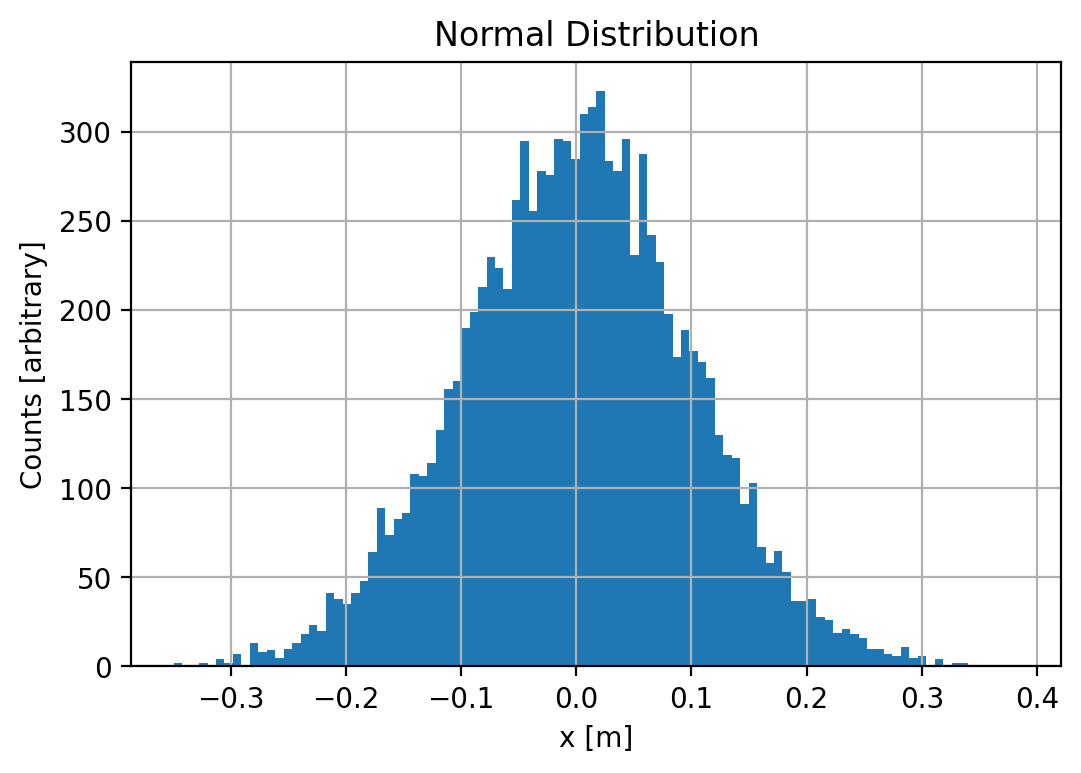

In [33]:
fig=plt.figure(figsize=(6, 4), dpi= 200, facecolor='w', edgecolor='k');

plt.xlabel('x [m]');
plt.ylabel('Counts [arbitrary]');
plt.title("Normal Distribution")

x_dat = test_Gaussian_bunch.get_x_array()

count, bins, ignored = plt.hist(x_dat, 100)
plt.grid()

2D Gaussian


In [34]:
Gaussian_bunch_2D = ParticleBunch.Gaussian_2D(1E6, 0., 0.1, 0, 0.1, 'x', 'y')

In [35]:
x_dat = Gaussian_bunch_2D.get_x_array()
xp_dat = Gaussian_bunch_2D.get_xp_array()
y_dat = Gaussian_bunch_2D.get_y_array()
yp_dat = Gaussian_bunch_2D.get_yp_array()
t_dat = Gaussian_bunch_2D.get_t_array()
pt_dat = Gaussian_bunch_2D.get_pt_array()

x_max = xp_max = y_max = yp_max = t_max = pt_max = x_min = xp_min = y_min = yp_min = t_min = pt_min = 0.

bin_size_x = 128
bin_size_y = 128

if np.max(x_dat) > x_max : x_max = np.max(x_dat)            
if np.max(xp_dat) > xp_max : xp_max = np.max(xp_dat)            
if np.max(y_dat) > y_max : y_max = np.max(y_dat)            
if np.max(yp_dat) > yp_max : yp_max = np.max(yp_dat)            
if np.max(t_dat) > t_max : t_max = np.max(t_dat)            
if np.max(pt_dat) > pt_max : pt_max = np.max(pt_dat)
    
if np.min(x_dat) < x_min : x_min = np.min(x_dat)            
if np.min(xp_dat) < xp_min : xp_min = np.min(xp_dat)            
if np.min(y_dat) < y_min : y_min = np.min(y_dat)            
if np.min(yp_dat) < yp_min : yp_min = np.min(yp_dat)            
if np.min(t_dat) < t_min : t_min = np.min(t_dat)            
if np.min(pt_dat) < pt_min : pt_min = np.min(pt_dat)

In [36]:
y_max

0.4841110596676892

In [37]:
y_min

-0.48277140516000067

In [38]:
plt.rcParams['figure.figsize'] = [4.0, 4.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 6
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['legend.handlelength'] = 5

plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['lines.markersize'] = 0.25

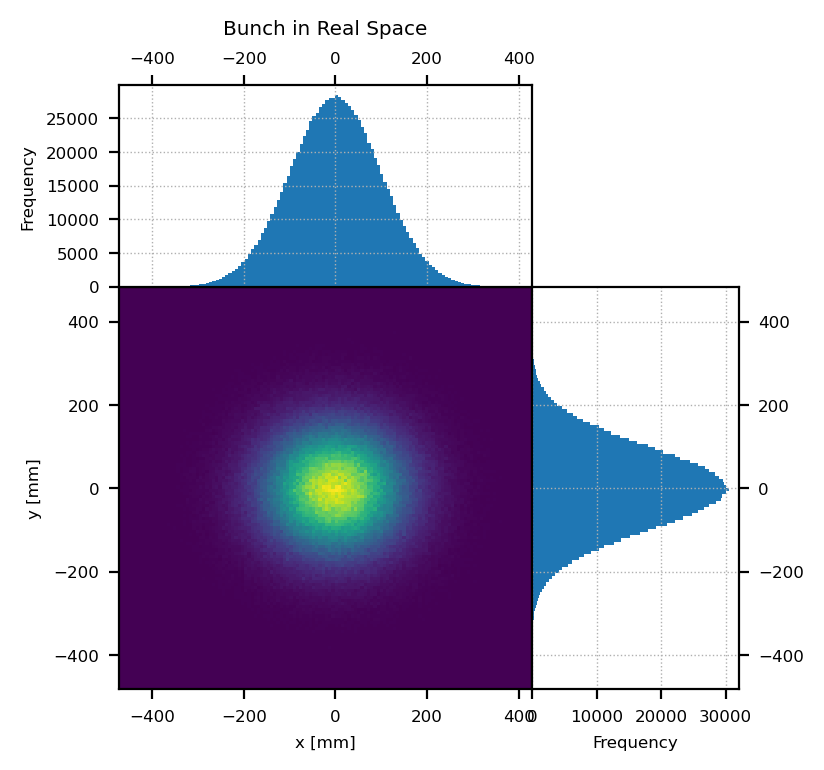

In [39]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in Real Space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, y_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[y_min*multi, y_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(y_dat*multi, bins = bin_size_y,  range = [y_min*multi, y_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


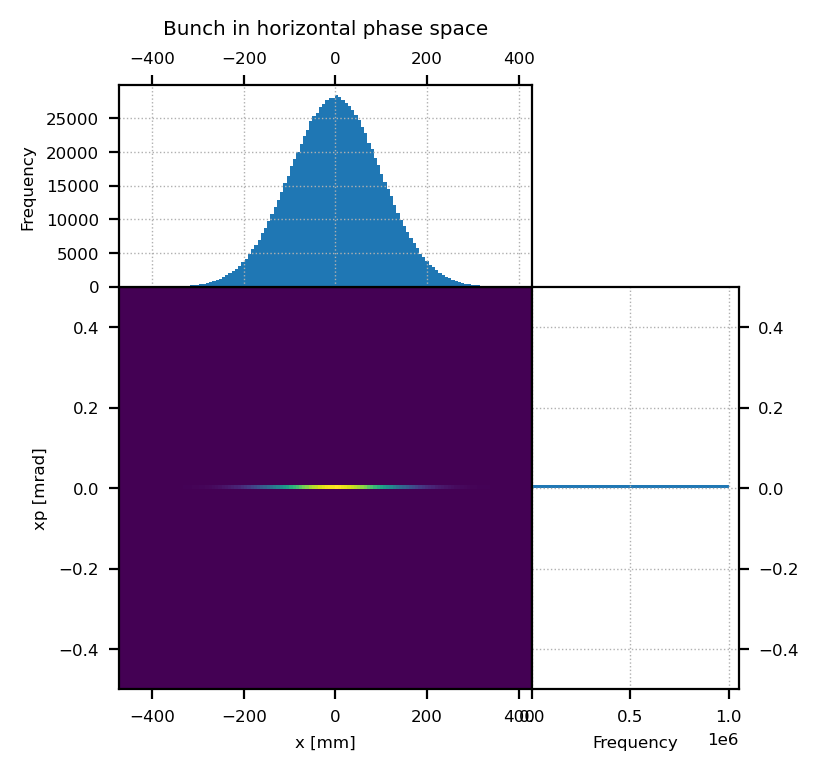

In [40]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in horizontal phase space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, xp_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[xp_min*multi, xp_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('xp [mrad]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(xp_dat*multi, bins = bin_size_y,  range = [xp_min*multi, xp_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


###  Test matching

In [41]:
beta_x = 3.215250830692
beta_y = 18.598794417925
alpha_x =  -0.547366008626
alpha_y =  2.750780302852
D_x =  -0.000103040524
D_xp = 0.001254020379
D_y = 0.
D_yp = 0.

In [42]:
Gaussian_bunch_2D.Match(beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp)

In [43]:
x_dat = Gaussian_bunch_2D.get_x_array()
xp_dat = Gaussian_bunch_2D.get_xp_array()
y_dat = Gaussian_bunch_2D.get_y_array()
yp_dat = Gaussian_bunch_2D.get_yp_array()
t_dat = Gaussian_bunch_2D.get_t_array()
pt_dat = Gaussian_bunch_2D.get_pt_array()

x_max = xp_max = y_max = yp_max = t_max = pt_max = x_min = xp_min = y_min = yp_min = t_min = pt_min = 0.

bin_size_x = 128
bin_size_y = 128

if np.max(x_dat) > x_max : x_max = np.max(x_dat)            
if np.max(xp_dat) > xp_max : xp_max = np.max(xp_dat)            
if np.max(y_dat) > y_max : y_max = np.max(y_dat)            
if np.max(yp_dat) > yp_max : yp_max = np.max(yp_dat)            
if np.max(t_dat) > t_max : t_max = np.max(t_dat)            
if np.max(pt_dat) > pt_max : pt_max = np.max(pt_dat)
    
if np.min(x_dat) < x_min : x_min = np.min(x_dat)            
if np.min(xp_dat) < xp_min : xp_min = np.min(xp_dat)            
if np.min(y_dat) < y_min : y_min = np.min(y_dat)            
if np.min(yp_dat) < yp_min : yp_min = np.min(yp_dat)            
if np.min(t_dat) < t_min : t_min = np.min(t_dat)            
if np.min(pt_dat) < pt_min : pt_min = np.min(pt_dat)

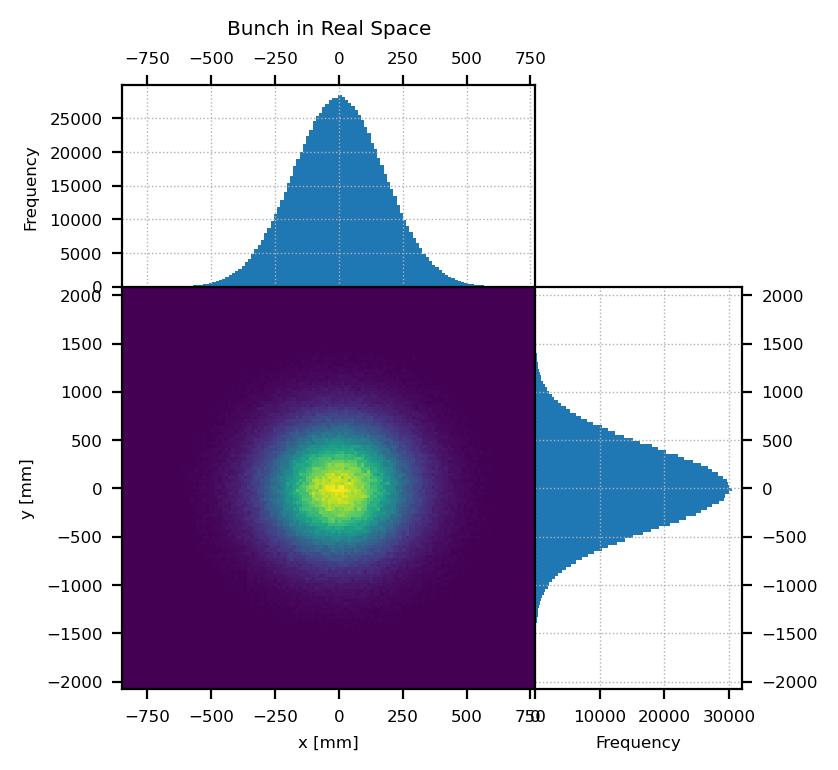

In [44]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in Real Space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, y_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[y_min*multi, y_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(y_dat*multi, bins = bin_size_y,  range = [y_min*multi, y_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


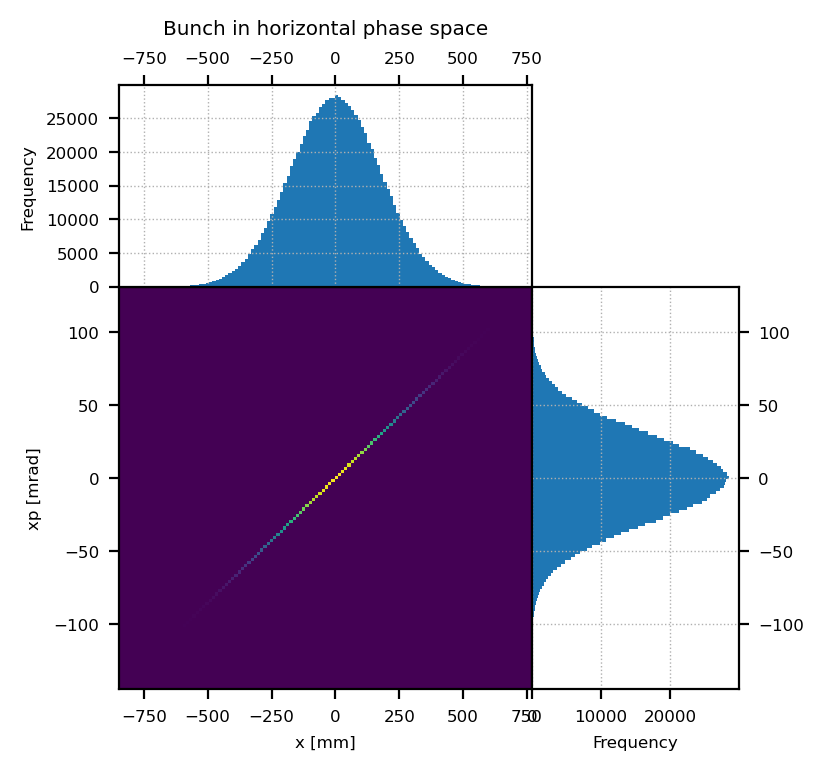

In [45]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in horizontal phase space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, xp_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[xp_min*multi, xp_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('xp [mrad]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(xp_dat*multi, bins = bin_size_y,  range = [xp_min*multi, xp_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


### 4D Gaussian & Match

In [46]:
std_dev_x = 0.063564167230132 / 6.
std_dev_xp = 1E-3
std_dev_y = 0.15287882248235696 / 6.
std_dev_yp = 1E-3
Gaussian_bunch_4D = ParticleBunch.Gaussian_4D(1E6, 0., std_dev_x, 0., std_dev_xp, 0., std_dev_y, 0., std_dev_yp)

In [47]:
x_dat = Gaussian_bunch_4D.get_x_array()
xp_dat = Gaussian_bunch_4D.get_xp_array()
y_dat = Gaussian_bunch_4D.get_y_array()
yp_dat = Gaussian_bunch_4D.get_yp_array()
t_dat = Gaussian_bunch_4D.get_t_array()
pt_dat = Gaussian_bunch_4D.get_pt_array()

x_max = xp_max = y_max = yp_max = t_max = pt_max = x_min = xp_min = y_min = yp_min = t_min = pt_min = 0.

bin_size_x = 128
bin_size_y = 128

if np.max(x_dat) > x_max : x_max = np.max(x_dat)            
if np.max(xp_dat) > xp_max : xp_max = np.max(xp_dat)            
if np.max(y_dat) > y_max : y_max = np.max(y_dat)            
if np.max(yp_dat) > yp_max : yp_max = np.max(yp_dat)            
if np.max(t_dat) > t_max : t_max = np.max(t_dat)            
if np.max(pt_dat) > pt_max : pt_max = np.max(pt_dat)
    
if np.min(x_dat) < x_min : x_min = np.min(x_dat)            
if np.min(xp_dat) < xp_min : xp_min = np.min(xp_dat)            
if np.min(y_dat) < y_min : y_min = np.min(y_dat)            
if np.min(yp_dat) < yp_min : yp_min = np.min(yp_dat)            
if np.min(t_dat) < t_min : t_min = np.min(t_dat)            
if np.min(pt_dat) < pt_min : pt_min = np.min(pt_dat)

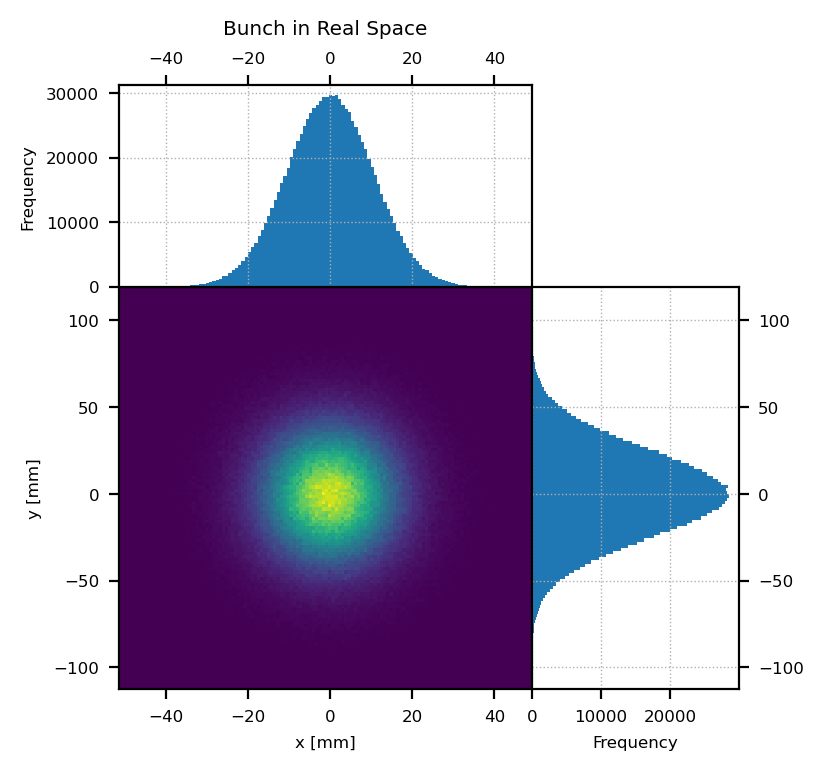

In [48]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in Real Space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, y_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[y_min*multi, y_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(y_dat*multi, bins = bin_size_y,  range = [y_min*multi, y_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


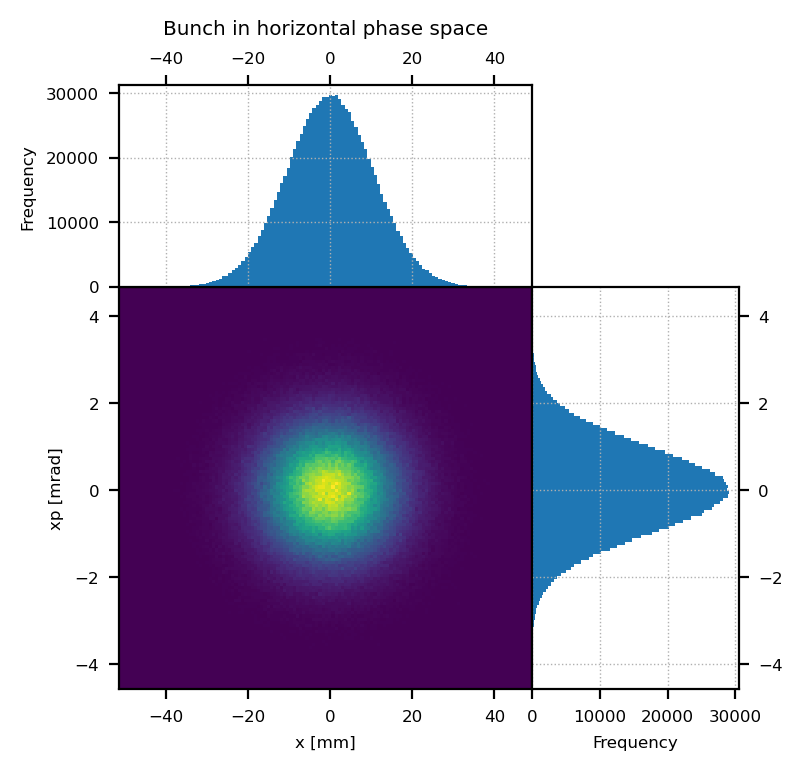

In [49]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in horizontal phase space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, xp_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[xp_min*multi, xp_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('xp [mrad]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(xp_dat*multi, bins = bin_size_y,  range = [xp_min*multi, xp_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


In [50]:
beta_x = 3.215250830692
beta_y = 18.598794417925
alpha_x =  -0.547366008626
alpha_y =  2.750780302852
D_x =  -0.000103040524
D_xp = 0.001254020379
D_y = 0.
D_yp = 0.

In [51]:
Gaussian_bunch_4D.Match(beta_x, beta_y, alpha_x, alpha_y, D_x, D_y, D_xp, D_yp)

In [52]:
x_dat = Gaussian_bunch_4D.get_x_array()
xp_dat = Gaussian_bunch_4D.get_xp_array()
y_dat = Gaussian_bunch_4D.get_y_array()
yp_dat = Gaussian_bunch_4D.get_yp_array()
t_dat = Gaussian_bunch_4D.get_t_array()
pt_dat = Gaussian_bunch_4D.get_pt_array()

x_max = xp_max = y_max = yp_max = t_max = pt_max = x_min = xp_min = y_min = yp_min = t_min = pt_min = 0.

bin_size_x = 128
bin_size_y = 128

if np.max(x_dat) > x_max : x_max = np.max(x_dat)            
if np.max(xp_dat) > xp_max : xp_max = np.max(xp_dat)            
if np.max(y_dat) > y_max : y_max = np.max(y_dat)            
if np.max(yp_dat) > yp_max : yp_max = np.max(yp_dat)            
if np.max(t_dat) > t_max : t_max = np.max(t_dat)            
if np.max(pt_dat) > pt_max : pt_max = np.max(pt_dat)
    
if np.min(x_dat) < x_min : x_min = np.min(x_dat)            
if np.min(xp_dat) < xp_min : xp_min = np.min(xp_dat)            
if np.min(y_dat) < y_min : y_min = np.min(y_dat)            
if np.min(yp_dat) < yp_min : yp_min = np.min(yp_dat)            
if np.min(t_dat) < t_min : t_min = np.min(t_dat)            
if np.min(pt_dat) < pt_min : pt_min = np.min(pt_dat)

In [53]:
y_min

-0.4860764545372459

In [54]:
y_max

0.5145790405890198

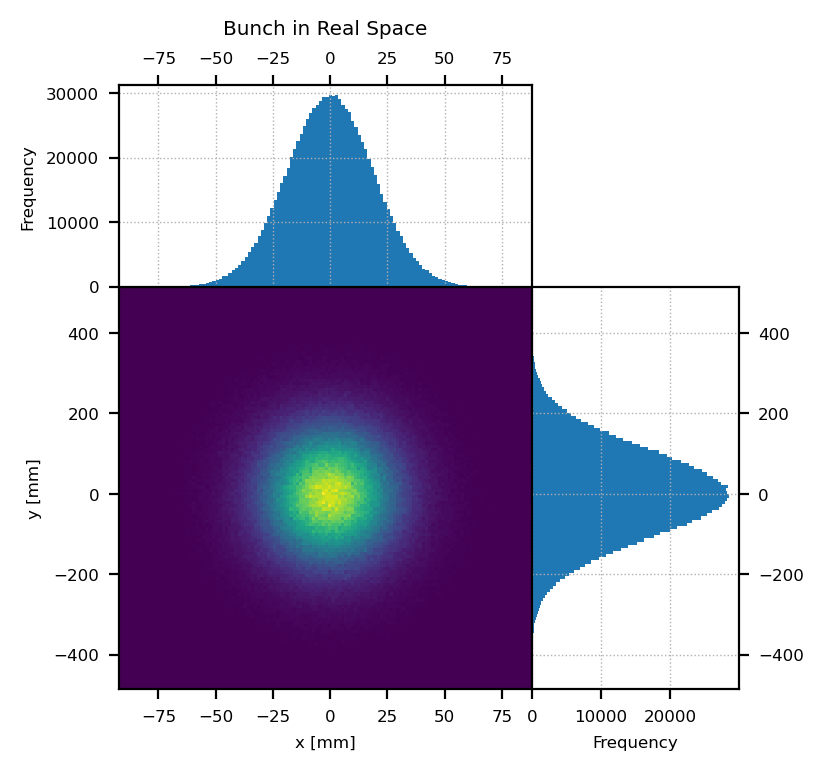

In [55]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in Real Space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, y_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[y_min*multi, y_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(y_dat*multi, bins = bin_size_y,  range = [y_min*multi, y_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


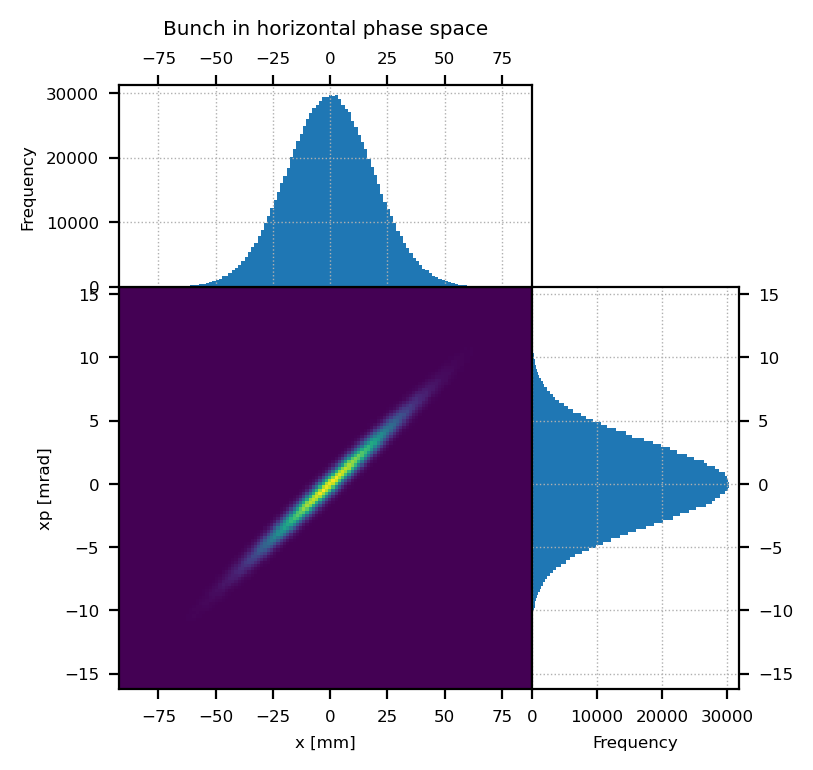

In [56]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in horizontal phase space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(x_dat*multi, xp_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[xp_min*multi, xp_max*multi]])
plt.xlabel('x [mm]')
plt.ylabel('xp [mrad]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(x_dat*multi, bins = bin_size_x,  range = [x_min*multi, x_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(xp_dat*multi, bins = bin_size_y,  range = [xp_min*multi, xp_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


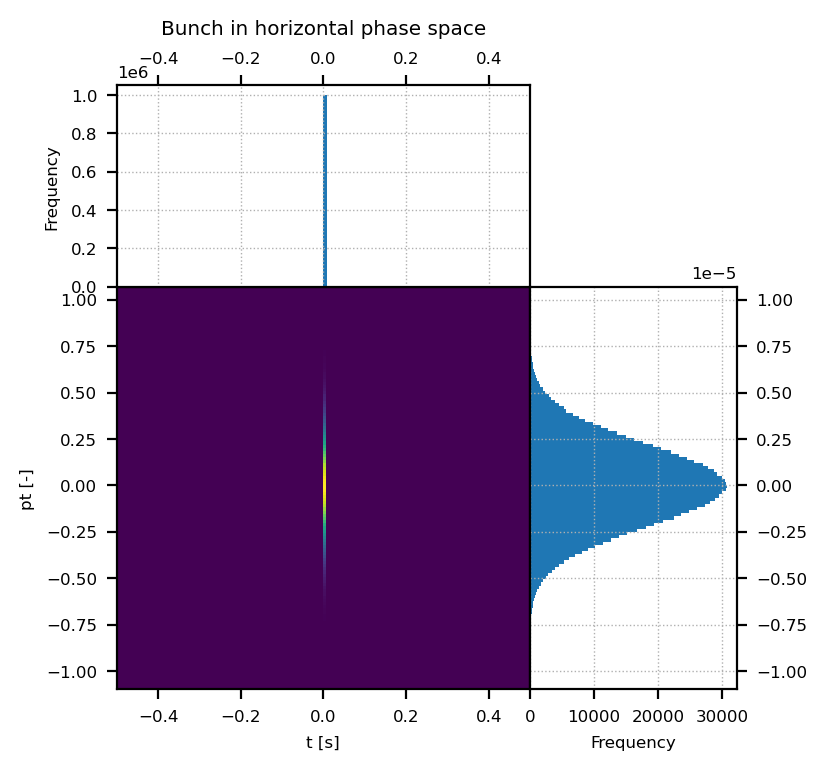

In [57]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in horizontal phase space'
multi = 1

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.hist2d(t_dat*multi, pt_dat*multi, bin_size_x, range=[[t_min*multi, t_max*multi],[pt_min*multi, pt_max*multi]])
plt.xlabel('t [s]')
plt.ylabel('pt [-]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(t_dat*multi, bins = bin_size_x,  range = [t_min*multi, t_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(pt_dat*multi, bins = bin_size_y,  range = [pt_min*multi, pt_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


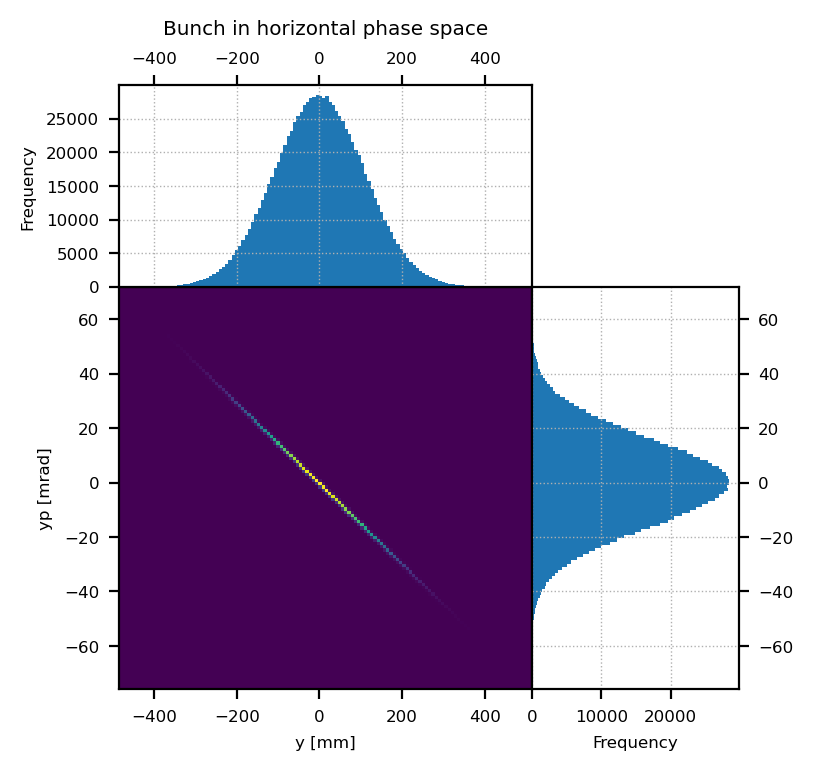

In [58]:
fig3 = plt.figure(1)
gridspec.GridSpec(3,3) # Create grid to resize subplots
fig3.subplots_adjust(hspace = 0) # Horizontal spacing between subplots
fig3.subplots_adjust(wspace = 0) # Vertical spacing between subplots

tit1 = 'Bunch in horizontal phase space'
multi = 1000

plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
#plt.hist2d(x_dat*multi, xp_dat*multi, bin_size_x, range=[[x_min*multi, x_max*multi],[xp_min*multi, xp_max*multi]])
plt.hist2d(y_dat*multi, yp_dat*multi, bin_size_x, range=[[y_min*multi, y_max*multi],[yp_min*multi, yp_max*multi]])
plt.xlabel('y [mm]')
plt.ylabel('yp [mrad]')
axis_main = plt.gca()
axis_main_ylim = axis_main.axes.get_ylim()
axis_main_xlim = axis_main.axes.get_xlim()

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)
plt.hist(y_dat*multi, bins = bin_size_x,  range = [y_min*multi, y_max*multi], density=False)
plt.grid(which='both', ls=':', lw=0.5)
plt.ylabel('Frequency')
axis_top = plt.gca()
axis_top.axes.set_xlim(axis_main_xlim)
axis_top.xaxis.set_ticks_position("top")
plt.title(tit1)

plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.hist(yp_dat*multi, bins = bin_size_y,  range = [yp_min*multi, yp_max*multi], density=False, orientation=u'horizontal')
plt.grid(which='both', ls=':', lw=0.5)
plt.xlabel('Frequency')
axis_right = plt.gca()
axis_right.axes.set_ylim(axis_main_ylim)
axis_right.yaxis.set_ticks_position("right")

figname = 'test.png'
#fig3.savefig(figname);


### bunch from file

In [59]:
test_bunch = ParticleBunch.empty(6)

In [60]:
test_bunch

In [61]:
f = open('MADX_input_particles.txt', 'w')
f.write('0.01\t0.0\t0.0\t0.0\t0.0\t0.0\n')
f.write('0.02\t0.0\t0.0\t0.0\t0.0\t0.0\n')
f.write('0.03\t0.0\t0.0\t0.0\t0.0\t0.0\n')
f.write('0.04\t0.0\t0.0\t0.0\t0.0\t0.0\n')
f.write('0.05\t0.0\t0.0\t0.0\t0.0\t0.0\n')
f.write('0.06\t0.0\t0.0\t0.0\t0.0\t0.0\n')
f.close()

In [62]:
test_bunch2 = ParticleBunch.from_file('MADX_input_particles.txt')

In [63]:
test_bunch2

In [64]:
x_dat = test_bunch2.get_x_array()
y_dat = test_bunch2.get_y_array()

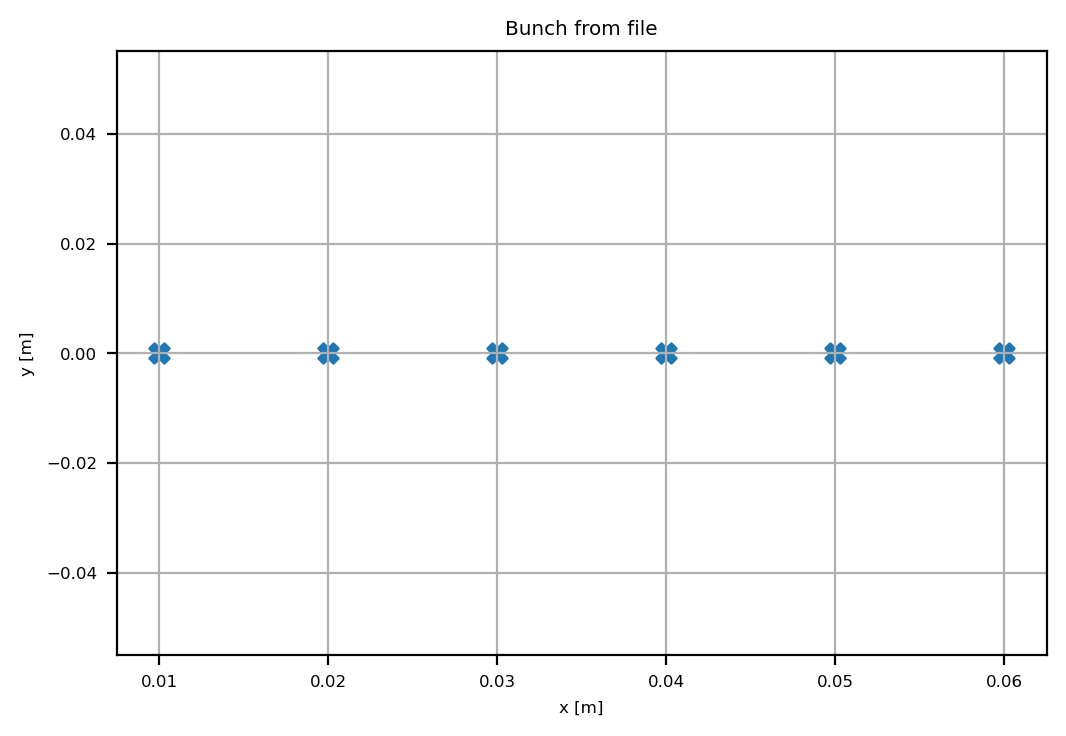

In [65]:
fig=plt.figure(figsize=(6, 4), dpi= 200, facecolor='w', edgecolor='k');

plt.xlabel('x [m]');
plt.ylabel('y [m]');
plt.title("Bunch from file")

plt.grid()
plt.scatter(x_dat,y_dat, s=50, marker='X')

### Test bunch functions
- Get N (total number of particles)
- Get ParticleArray from bunch
- Get a single particle from the bunch
- Get co-ordinates of a single particle

In [66]:
test_bunch.get_N()

6

In [67]:
partA = test_bunch.get_ParticleArray()

In [68]:
partA

array([<__main__.Particle object at 0x7ff920d23070>,
       <__main__.Particle object at 0x7ff9209fa8e0>], dtype=object)

In [69]:
part = test_bunch.get_Particle(2)

In [70]:
print(part)

In [71]:
part.get_coordinates()

array([0., 0., 0., 0., 0., 0.])

In [72]:
test_bunch2.get_N()

6

### Test bunch iterator
- manual iterations using next() until an error occurs
- iteration in a for loop to test automatic StopIteration
- print particle co-ordinates within bunch for loop

In [73]:
i = iter(test_bunch2)

In [74]:
print(next(i))

In [75]:
print(next(i))

In [76]:
print(next(i))

In [77]:
print(next(i))

In [78]:
print(next(i))

In [79]:
print(next(i))

In [80]:
fail_test = False
if fail_test: print(next(i))

In [81]:
for i in test_bunch2:
    print(i.get_coordinates())

[0.01 0.   0.   0.   0.   0.  ]
[0.02 0.   0.   0.   0.   0.  ]
[0.03 0.   0.   0.   0.   0.  ]
[0.04 0.   0.   0.   0.   0.  ]
[0.05 0.   0.   0.   0.   0.  ]
[0.06 0.   0.   0.   0.   0.  ]


### Test printing of bunch file

In [82]:
test_bunch2.print_MADX_file('MADX_bunch.madx')
test_bunch2.print_PTC_file('PTC_bunch.ptc')
test_bunch2.print_file('RAW_bunch.dat')

In [83]:
Gaussian_bunch_4D.print_MADX_file('Gaussian_1E6.madx')
Gaussian_bunch_4D.print_PTC_file('Gaussian_1E6.ptc')

---
# Load CERN Proton Synchrotron Wirescanner data

For comparison to normal distribution

In [84]:
CERN_data = pnd.read_pickle('MD4224_H.pkl')

In [85]:
CERN_data

,PR.BWS.65.H_ROT:ACQ_DELAY,PR.BWS.65.H_ROT:PROF_POSITION_IN,PR.BWS.65.H_ROT:PROF_DATA_IN,cycleStamp,2ndMoment H,sig H,sig errH,A H,mu H,position H,...,intensity,losses,ratio,emittance H,betx,bety,dx,emittance H noDisp,emittance H 2ndMoment noDisp,emittance H 2ndMoment
2018-09-04 08:30:23.500,172.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.173300683154985, 0.173502430703752, 0.17249...",1.536050e+09,4.376493,4.411930986822637,0.010816,7.104645728686517,-2.737597599968522,"[-26.44740240003148, -26.31840240003148, -26.2...",...,7.301678e+11,1.755472,0.982445,1.072059,22.435882,11.715731,3.413603,1.960295,1.928930,1.040693
2018-09-04 08:31:07.900,172.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.174717857718864, 0.17512488920122, 0.174514...",1.536050e+09,4.259797,4.385077923670447,0.011540,6.889804203620628,-2.6681059516376338,"[-26.289894048362363, -26.192894048362366, -26...",...,7.119099e+11,1.411161,0.985888,1.039390,22.392001,11.721015,3.434507,1.940300,1.831016,0.930105
2018-09-04 08:31:52.300,172.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.17573721506667, 0.175532868924527, 0.176556...",1.536050e+09,4.351413,4.434069219375807,0.010679,6.972747213985072,-2.6428228411117747,"[-26.575177158888224, -26.380177158888223, -26...",...,7.243861e+11,1.241589,0.987584,1.073654,22.339713,11.726460,3.457001,1.988541,1.915094,1.000208
2018-09-04 08:33:21.100,172.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.175941799097855, 0.17512488920122, 0.175737...",1.536050e+09,4.377512,4.468284998488029,0.011512,6.719656512893831,-2.4287820659879413,"[-26.789217934012058, -26.62721793401206, -26....",...,7.017158e+11,1.237806,0.987622,1.084702,22.207503,11.737483,3.506113,2.031370,1.949674,1.003006
2018-09-04 08:34:49.900,172.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.17573721506667, 0.17573721506667, 0.1755328...",1.536050e+09,4.517287,4.5937560326213065,0.010113,6.964483463383702,-3.0145971809522223,"[-27.43940281904778, -27.34140281904778, -27.3...",...,7.227126e+11,0.887386,0.991126,1.180333,22.035852,11.748196,3.559735,2.163780,2.092342,1.108895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-04 14:25:35.500,185.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.175532868924527, 0.176556981296645, 0.17655...",1.536071e+09,4.587713,4.595164230002008,0.011664,7.154781573808689,-4.736952242861165,"[-27.510047757138835, -27.380047757138833, -27...",...,7.186044e+11,0.891138,0.991089,1.192584,22.133896,11.742459,3.530239,2.155516,2.148532,1.185599
2018-09-04 14:27:04.300,185.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.175532868924527, 0.175328760394808, 0.17492...",1.536071e+09,4.589034,4.723799320852513,0.010192,7.206005832020676,-5.00246895617773,"[-28.224531043822267, -28.094531043822272, -28...",...,7.359496e+11,1.158940,0.988411,1.294517,21.930586,11.753497,3.589008,2.299004,2.169699,1.165212
2018-09-04 14:28:33.100,185.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.173502430703752, 0.173704413116415, 0.17390...",1.536071e+09,4.788107,4.873459533906334,0.011332,7.2788615731523105,-5.31168394912955,"[-29.192316050870446, -29.094316050870447, -29...",...,7.295592e+11,0.898823,0.991012,1.421885,21.655891,11.764465,3.657010,2.478026,2.391986,1.335846
2018-09-04 14:30:01.900,185.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[0.17635168193542, 0.175328760394808, 0.174311...",1.536071e+09,4.974505,5.100428754397238,0.014049,7.221624418572438,-5.973222967662587,"[-30.598777032337416, -30.368777032337412, -30...",...,7.196695e+11,0.869757,0.991302,1.638968,21.265534,11.775665,3.740290,2.764039,2.629242,1.504171


In [86]:
CERN_data.keys()

Index(['PR.BWS.65.H_ROT:ACQ_DELAY', 'PR.BWS.65.H_ROT:PROF_POSITION_IN',
       'PR.BWS.65.H_ROT:PROF_DATA_IN', 'cycleStamp', '2ndMoment H', 'sig H',
       'sig errH', 'A H', 'mu H', 'position H', 'profile H',
       'PR_SCBFC.Samples.value.samples', 'Qx', 'Qy', 'intensity', 'losses',
       'ratio', 'emittance H', 'betx', 'bety', 'dx', 'emittance H noDisp',
       'emittance H 2ndMoment noDisp', 'emittance H 2ndMoment'],
      dtype='object')

In [87]:
operational_tune_shots = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
len(operational_tune_shots)

16

In [88]:
chosen_shot = 10
print(operational_tune_shots[chosen_shot])
CERN_x_dat = CERN_data['position H'].iloc[operational_tune_shots[chosen_shot]]
CERN_y_dat = CERN_data['profile H'].iloc[operational_tune_shots[chosen_shot]]

10


---
### Might have to run this cell twice to get a nice plot

In [100]:
x_dat = Gaussian_bunch_4D.get_x_array()

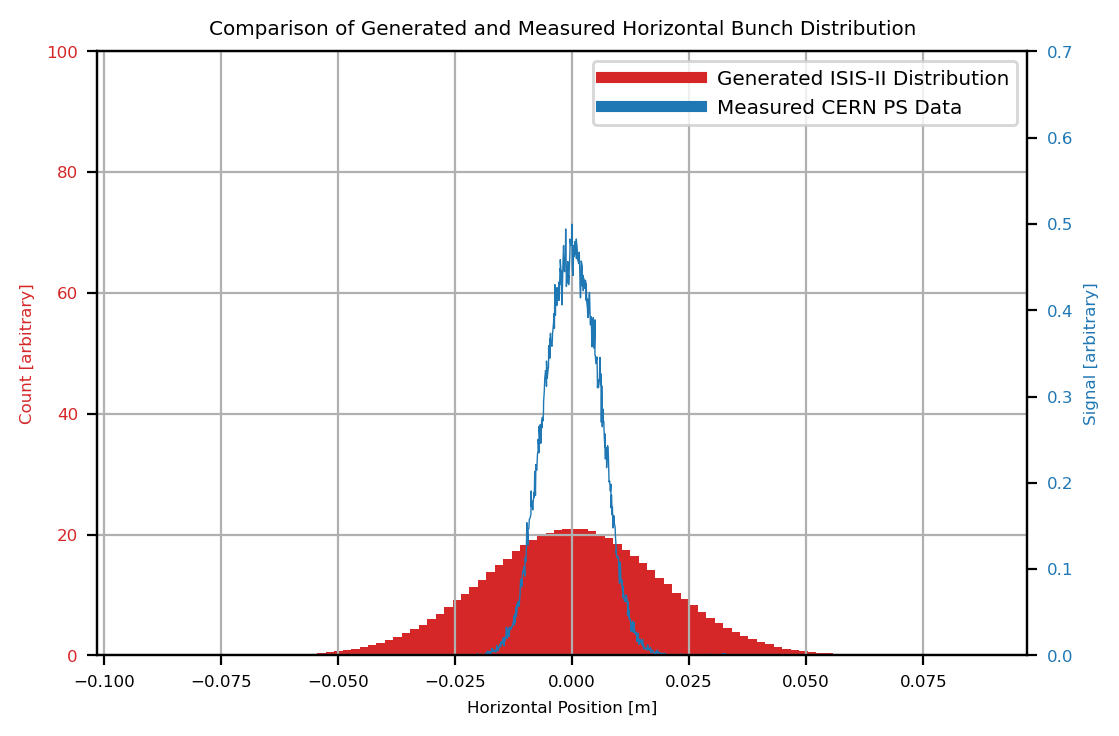

In [103]:
fig, ax1 = plt.subplots(figsize=(6, 4), dpi= 200, facecolor='w', edgecolor='k')

plt.title('Comparison of Generated and Measured Horizontal Bunch Distribution')
ax1.set_xlabel('Horizontal Position [m]');
ax1.set_ylabel('Count [arbitrary]', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 100)
count, bins, ignored = ax1.hist(x_dat, 100, density = True, color='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylabel('Signal [arbitrary]', color='tab:blue')
ax2.set_ylim(0., 0.7)

ax1.grid(which='both');

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]

ax1.legend(custom_lines, ['Generated ISIS-II Distribution', 'Measured CERN PS Data'])

ax2.plot(CERN_x_dat/1000., CERN_y_dat, color='tab:blue')
fig.savefig('CERN_data_cf_generated_Gaussian.png');

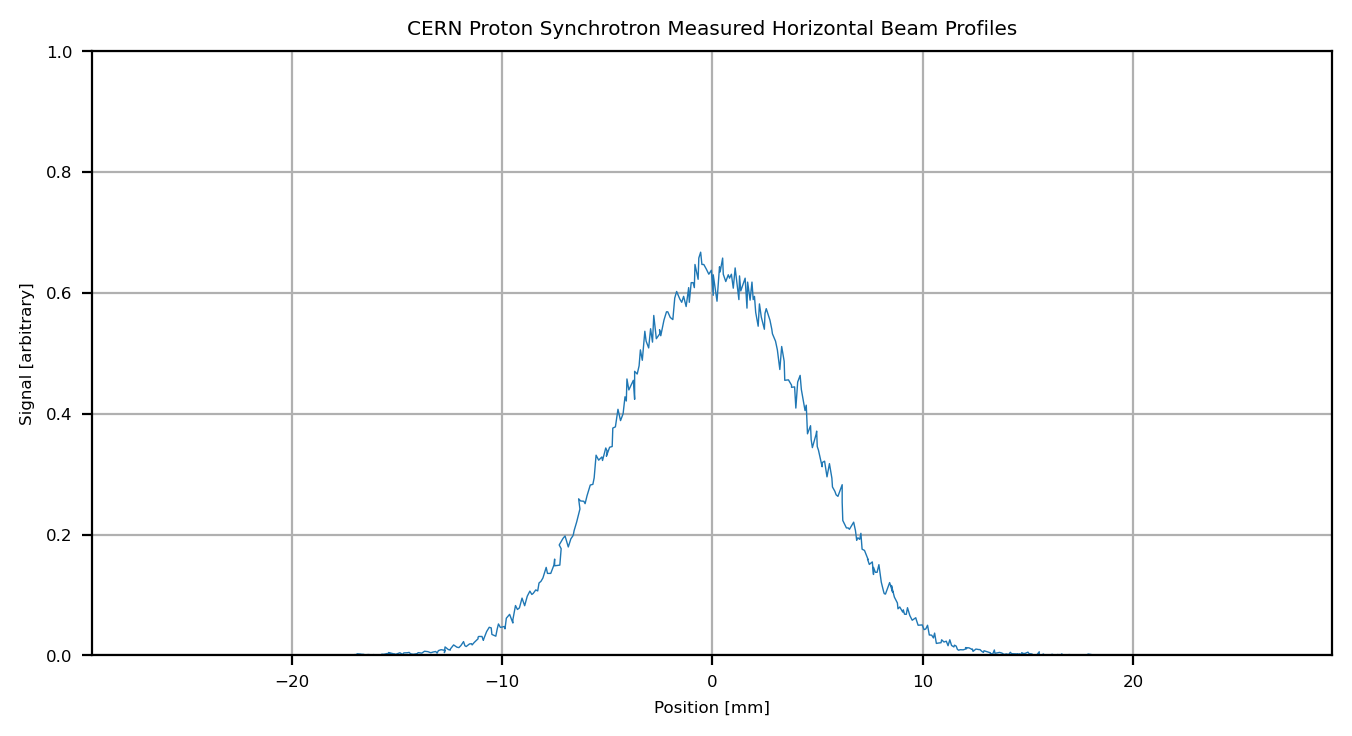

In [90]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k');


plt.xlabel('Position [mm]');
plt.ylabel('Signal [arbitrary]');

plt.title('CERN Proton Synchrotron Measured Horizontal Beam Profiles')

plt.plot(CERN_x_dat, CERN_y_dat)

plt.ylim(0, 1);
#plt.xlim(-20, 20)

#plt.legend();
plt.grid();
fig.savefig('CERN_data_single_bunch.png');

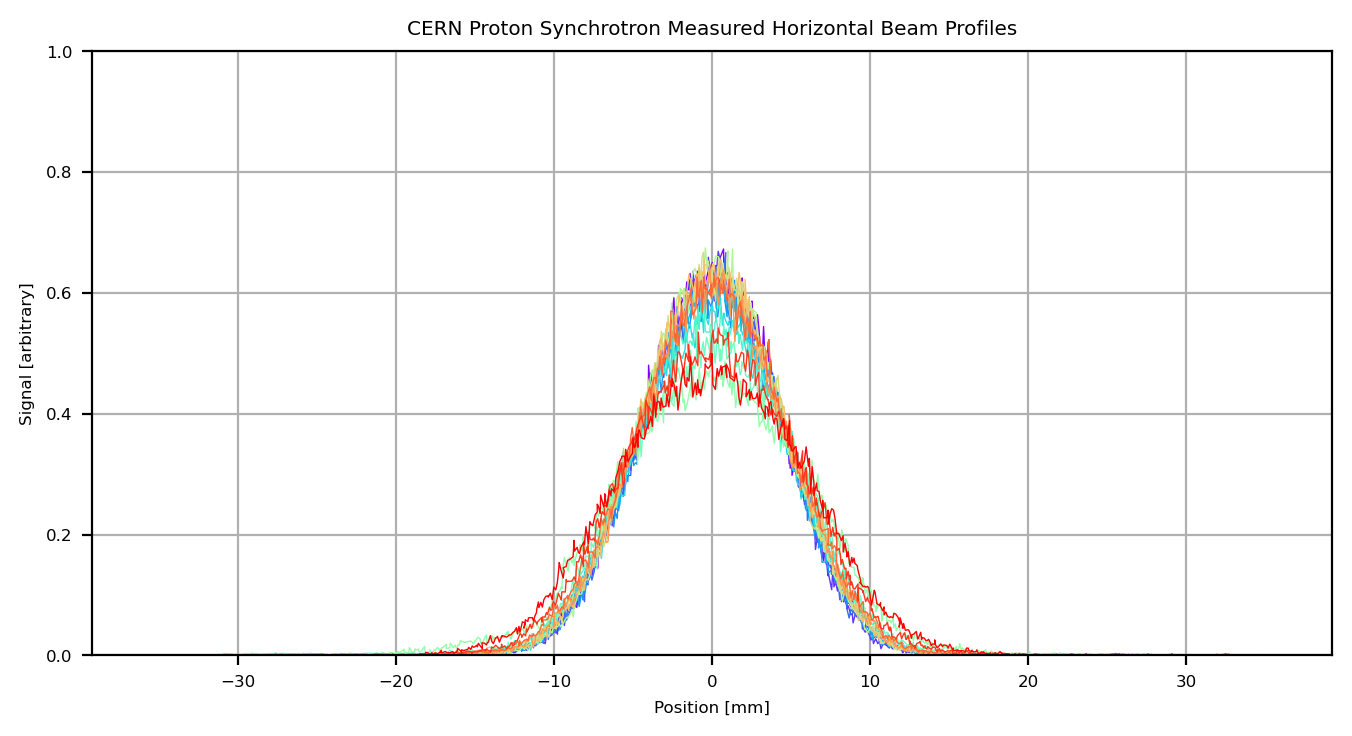

In [91]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k');


plt.xlabel('Position [mm]');
plt.ylabel('Signal [arbitrary]');

plt.title('CERN Proton Synchrotron Measured Horizontal Beam Profiles')

colors = cm.rainbow(np.linspace(0, 1, len(operational_tune_shots)))
j = 0

for i in operational_tune_shots:
    CERN_x_dat = CERN_data['position H'].iloc[i]
    CERN_y_dat = CERN_data['profile H'].iloc[i]
    plt.plot(CERN_x_dat, CERN_y_dat, color=colors[j])
    j+=1

plt.ylim(0, 1);
#plt.xlim(-20, 20)

#plt.legend();
plt.grid();
fig.savefig('CERN_data_multiple_bunches.png');

---
# Random Distributions

We must populate the bunch using random numbers sampled from specific distribution types:
- uniform
- Gaussian (also called Normal)

From Kayva:

In [92]:
def random_number_normal():
    import random
    n = np.random.normal(0.5, 0.01, size=None)
    print(n)

In [93]:
def random_number_uniform():
    import random
    u = np.random.uniform(0,1, size=None)
    print(u)

Updated:

In [94]:
def Gaussian_generator(): 
    within_limits = True
    while within_limits:
        n = np.random.normal(0.5, 0.15, size=None)
        if n <= 1.0 and n >= 0.0: within_limits = False
            
    return n 

In [95]:
def Uniform_generator(): 
    within_limits = True
    while within_limits:
        n = np.random.uniform(0,1, size=None)
        if n <= 1.0 and n >= 0.0: within_limits = False
            
    return n 

In [96]:
data = []
for i in range(100000):
    data.append(Gaussian_generator())

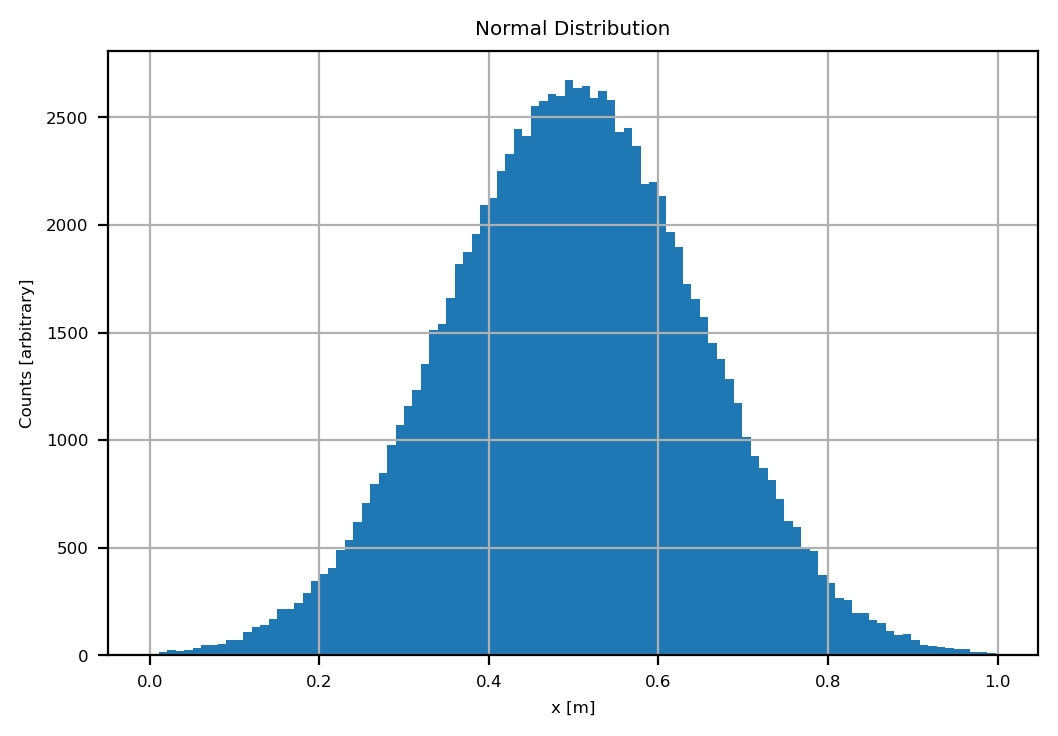

In [97]:
fig=plt.figure(figsize=(6, 4), dpi= 200, facecolor='w', edgecolor='k');

plt.xlabel('x [m]');
plt.ylabel('Counts [arbitrary]');
plt.title("Normal Distribution")

count, bins, ignored = plt.hist(data, 100)
plt.grid()

In [98]:
data = []
for i in range(100000):
    data.append(Uniform_generator())

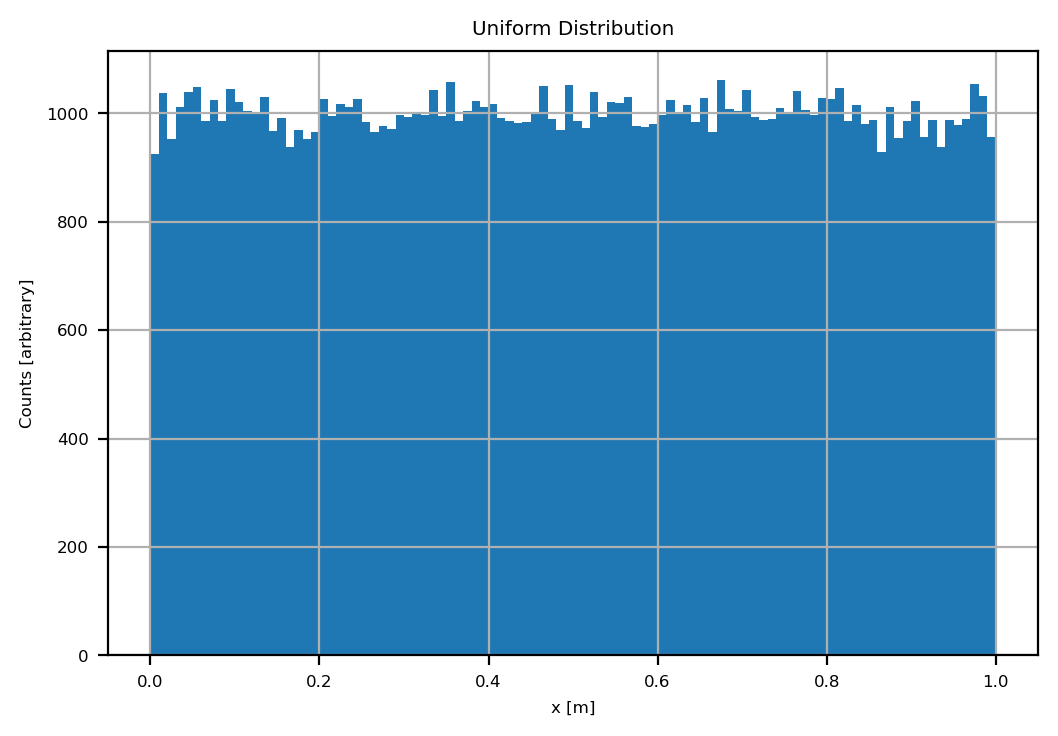

In [99]:
fig=plt.figure(figsize=(6, 4), dpi= 200, facecolor='w', edgecolor='k');

plt.xlabel('x [m]');
plt.ylabel('Counts [arbitrary]');
plt.title("Uniform Distribution")

count, bins, ignored = plt.hist(data, 100)
plt.grid()